<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [356]:
%load_ext autoreload
%autoreload 2


import numpy as numpy
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform

import seaborn as sns
import matplotlib.pyplot as plt

from src import soporte_sistemas_recomendacion as sr

import re
import spacy
import contractions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [357]:
df = pd.read_csv('datos/datos.csv', index_col=0).reset_index(drop=True)


In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewId            10000 non-null  object 
 1   reviewDate          10000 non-null  object 
 2   mainDepartment      10000 non-null  object 
 3   subDepartment       10000 non-null  object 
 4   productName         10000 non-null  object 
 5   reviewTitle         9995 non-null   object 
 6   reviewStar          10000 non-null  float64
 7   reviewText          9999 non-null   object 
 8   inconsistentStatus  10000 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 703.3+ KB


In [359]:
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


In [360]:
df.nunique()

reviewId              10000
reviewDate             1487
mainDepartment            5
subDepartment            27
productName              99
reviewTitle            8361
reviewStar                5
reviewText             9928
inconsistentStatus        2
dtype: int64

In [361]:
df['mainDepartment'].value_counts()

mainDepartment
Computers                   3071
Beauty and Personal Care    2104
Electronics                 1747
Home and Kitchen            1662
Sports and Outdoors         1416
Name: count, dtype: int64

In [362]:
df['subDepartment'].value_counts()

subDepartment
Sports & Fitness                      710
Outdoor Recreation                    706
Makeup                                387
Hair Care                             372
Kitchen and Dining                    363
Men's Accessories                     360
Video games and accessories           360
Laptop Accessories                    357
GPS and Navigation                    353
Heating, Cooling & Air Quality        351
Headphones                            351
Foot,Hand & Nail Care                 349
Camera and Accessories                342
Men's Clothing                        341
CellPhones and Accessories            341
Computer Accessories & Peripherals    340
Shave & Hair Removal                  339
Men's Watches                         339
Computers & Tablets                   336
Men's Shoes                           335
Networking Products                   334
Skin Care                             334
Furniture                             332
Data Storage        

In [363]:
df.groupby(['mainDepartment', 'subDepartment'])['subDepartment'].count()

mainDepartment            subDepartment                     
Beauty and Personal Care  Foot,Hand & Nail Care                 349
                          Fragrance                             323
                          Hair Care                             372
                          Makeup                                387
                          Shave & Hair Removal                  339
                          Skin Care                             334
Computers                 Computer Accessories & Peripherals    340
                          Computers & Tablets                   336
                          Data Storage                          329
                          Laptop Accessories                    357
                          Men's Accessories                     360
                          Men's Clothing                        341
                          Men's Shoes                           335
                          Men's Watches                

In [364]:
df[df.isna().any(axis=1)]

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
4333,R364W01TMAE95T,"Reviewed in the United States on March 25, 2021",Electronics,Video games and accessories,BENGOO G9000 Stereo Gaming Headset for PS4 PC ...,NaN,2.0,"It was clear to hear but speaking for me, no o...",0
6267,R1V4YJT6IDSQ5V,"Reviewed in the United States on December 7, 2020",Beauty and Personal Care,Hair Care,Castor Oil USDA Organic Cold-Pressed (16oz) 10...,NaN,4.0,NaN,1
6488,RD6S1BD3L11QT,"Reviewed in the United States on July 6, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",NaN,1.0,It didn't work as well as we had anticipated.,0
7010,RLCUK197Z6DGX,"Reviewed in the United States on August 4, 2021",Computers,Men's Shoes,Crocs Men's and Women's Classic Clog,NaN,1.0,"This order is not in my possession, yet. Addi...",1
9026,R25QX3HWD0F5SK,"Reviewed in the United States on June 25, 2019",Beauty and Personal Care,Fragrance,"RawChemistry Pheromone Cologne, for Him [Attra...",NaN,3.0,FOR EVERYDAY USE,0


In [365]:
df.dropna(inplace=True)

In [366]:
df.shape

(9995, 9)

In [367]:
df.duplicated().sum()

np.int64(0)

In [368]:
df.nunique()

reviewId              9995
reviewDate            1487
mainDepartment           5
subDepartment           27
productName             99
reviewTitle           8361
reviewStar               5
reviewText            9924
inconsistentStatus       2
dtype: int64

In [369]:
df.describe()

,reviewStar,inconsistentStatus
count,9995.000000,9995.000000
mean,3.003902,0.447824
std,1.410418,0.497295
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,4.000000,1.000000
max,5.000000,1.000000


In [370]:
# stop_words = set(stopwords.words('english'))
# nlp = spacy.load('en_core_web_sm')

In [371]:
# Cargar el modelo de SpaCy fuera de la función para mejorar el rendimiento
def limpiar_texto(texto):

    texto = contractions.fix(texto)
    # Convierte a minúsculas
    texto = texto.lower()
    # Elimina signos de puntuación
    texto = re.sub(r'[.,;]', '', texto)
    # Elimina números
    # texto = re.sub(r'\d+', '', texto)
    # Elimina caracteres especiales
    texto = re.sub(r'[^\w\s]', '', texto)
    # Elimina espacios dobles y saltos de línea
    texto = re.sub(r'\s+', ' ', texto)
    # Quita espacios al inicio y al final
    texto = texto.strip()
    # doc = nlp(texto)
    return texto

df['texto_limpio'] = df['productName'].apply(lambda x: limpiar_texto(x))

# Mostrar las primeras filas
df.head(3)

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,texto_limpio
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1,doctor developed copper wrist brace carpal tun...
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0,fruit of the loom mens coolzone boxer briefs
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0,tplink ac750 wifi extender re220 covers up to ...


In [372]:
df['productName'].iloc[1]

"Fruit of the Loom Men's Coolzone Boxer Briefs"

## Sistema de recomendación

In [373]:
df['columna_combi'] = df['texto_limpio'] + ' ' + df['subDepartment']

In [374]:
vectorize = CountVectorizer(max_features=250, stop_words='english')
vectorize

CountVectorizer(max_features=250, stop_words='english')

In [387]:
df['columna_combi'].iloc[0]

'doctor developed copper wrist brace carpal tunnel wrist brace wrist support wrist splint hand brace fda class i medical device doctor handbook night support for women men right left hands single Outdoor Recreation'

In [375]:
x = vectorize.fit_transform(df['columna_combi']).toarray() #tomo para mi modelo a mi columna genres
x

array([[0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [376]:
similarity = cosine_similarity(x)
similarity

array([[1.        , 0.09128709, 0.        , ..., 0.        , 0.09128709,
        0.        ],
       [0.09128709, 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.09128709, 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [377]:
def get_index_from_name(name):
    return df[df.productName == name].index[0]

def get_name_from_index(index):
    return df[df.index == index]['productName'].values[0]

In [378]:
user_like_product = "Fruit of the Loom Men's Coolzone Boxer Briefs" #hago la prueba con este juego

In [379]:
game_index = get_index_from_name(user_like_product) #busco el indice de mi pelicula
game_index

np.int64(1)

In [380]:
similarity[game_index] #busco la similitud de mi juego elegido con los demás

array([0.09128709, 1.        , 0.        , ..., 0.        , 1.        ,
       0.        ])

In [381]:
similar_games=list(enumerate(similarity[game_index]))

In [382]:
similar_games[:10]

[(0, np.float64(0.0912870929175277)),
 (1, np.float64(1.0000000000000002)),
 (2, np.float64(0.0)),
 (3, np.float64(0.0)),
 (4, np.float64(0.0)),
 (5, np.float64(0.0)),
 (6, np.float64(0.0912870929175277)),
 (7, np.float64(0.0)),
 (8, np.float64(0.2041241452319315)),
 (9, np.float64(0.0))]

In [383]:
sorted_games =sorted(similar_games, key=lambda x: x[1], reverse=True) #Lo ordenamos para que nos de las pelis que más se parecen a nuestra peli
top_game ={}
for i in sorted_games[1:11]: # le digo que me devuelva las primera 20 pelis sin contar ella misma
    top_game[get_name_from_index(i[0])]=i[1]
top_game

{"Fruit of the Loom Men's Coolzone Boxer Briefs": np.float64(1.0000000000000002)}

C:\Users\DELL\AppData\Local\Temp\ipykernel_8332\1105178153.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


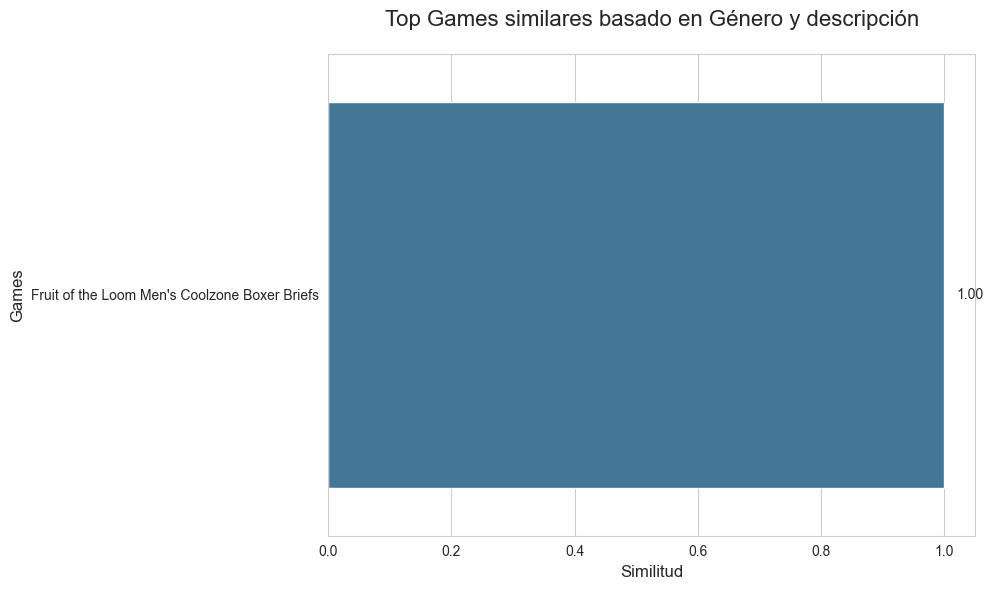

In [384]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    x=list(top_game.values()), 
    y=list(top_game.keys()), 
    palette="mako"
)

plt.title("Top Games similares basado en Género y descripción", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Games", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_game.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()